# mlp

隐藏层权重可视化

In [2]:
import mynn as nn
from draw_tools.plot import plot

import numpy as np
from struct import unpack
import matplotlib.pyplot as plt


def visualize_first_layer_weights(model):
    # 找到第一个线性层
    first_linear_layer = None
    for layer in model.layers:
        if isinstance(layer, nn.op.Linear):  
            first_linear_layer = layer
            break
    
    if first_linear_layer is None:
        print("No linear layer found")
        return
    
    # 获取权重矩阵（注意权重矩阵形状是 [输入维度, 输出维度]）
    weights = first_linear_layer.W  # 直接访问W属性
    
    # 可视化设置
    plt.figure(figsize=(12, 8))
    n_rows = 5
    n_cols = 8
    
    # 绘制前32个神经元的权重
    for i in range(n_rows * n_cols):
        plt.subplot(n_rows, n_cols, i+1)
        # 获取第i个神经元的权重并reshape为28x28
        weight_map = weights[:, i].reshape(28, 28)
        # 使用对称的归一化显示正负权重
        plt.imshow(weight_map, cmap='grey', vmin=-abs(weights).max(), vmax=abs(weights).max())
        # plt.imshow(weight_map, cmap='grey', interpolation='nearest')
        plt.axis('off')
    
    plt.suptitle('First Layer Weight Visualization')
    plt.tight_layout()
    plt.show()

# 加载保存的模型
def load_and_visualize(model_path):
    # 创建空模型
    model = nn.models.Model_MLP()
    # 加载参数
    model.load_model(model_path)
    # 可视化
    visualize_first_layer_weights(model)


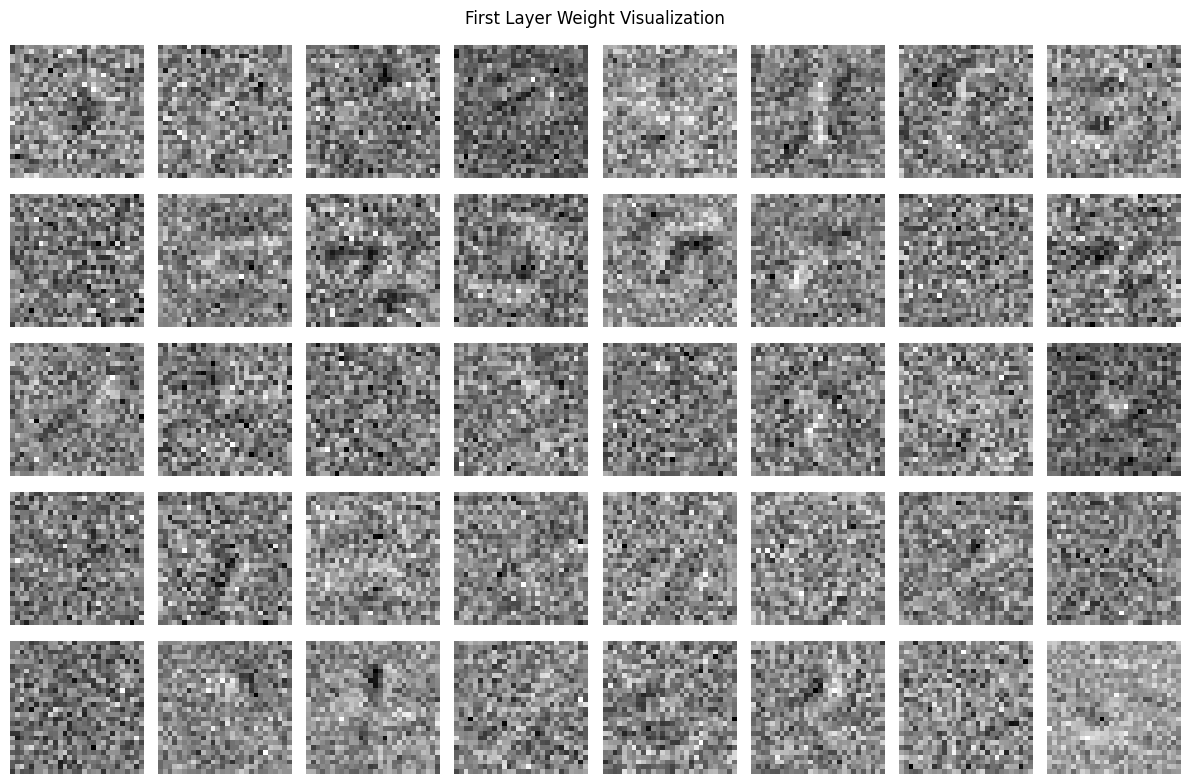

In [18]:
# 执行可视化
load_and_visualize('saved_models/l2_1e-4/best_model.pickle')

十个类别的templates可视化

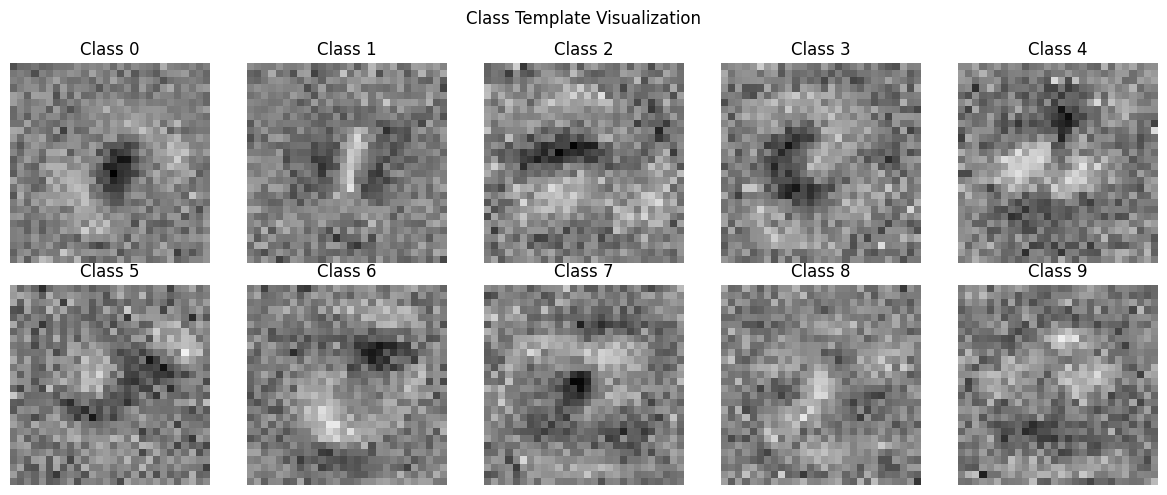

In [ ]:
def visualize_class_templates(model):
    # 找到所有线性层
    linear_layers = [layer for layer in model.layers if isinstance(layer, nn.op.Linear)]

    # 获取第一个和第二个线性层的权重
    first_linear = linear_layers[0]
    second_linear = linear_layers[1]
    W1 = first_linear.W  # 形状 (784, 128)
    W2 = second_linear.W  # 形状 (128, 10)
    
    # 计算类别模板（784, 10）
    templates = W1 @ W2 
    
    plt.figure(figsize=(12, 5))
    n_rows = 2
    n_cols = 5
    
    # 绘制每个类别的模板
    for i in range(10):
        plt.subplot(n_rows, n_cols, i+1)
        template = templates[:, i].reshape(28, 28)
        # 对称的归一化显示正负权重
        max_val = np.max(np.abs(templates))
        plt.imshow(template, cmap='gray', vmin=-max_val, vmax=max_val)
        plt.title(f"Class {i}")
        plt.axis('off')
    
    plt.suptitle('Class Template Visualization')
    plt.tight_layout()
    plt.show()

model = nn.models.Model_MLP()
model.load_model('saved_models/l2_1e-4/best_model.pickle')
visualize_class_templates(model)   

# cnn

加载模型：

In [3]:
conv_configs = [
    {
        'type': 'conv',
        'in_channels': 1,          # MNIST灰度图通道数
        'out_channels': 16,       
        'kernel_size': 5,
        'stride': 1,
        'padding': 0,
        'weight_decay': True,      # 可选：添加正则化
        'weight_decay_lambda': 1e-4
    },
    {
        'type': 'pool',
        'pool_type': 'avg',
        'kernel_size': 2,
        'stride': 2
    },
    {
        'type': 'conv',
        'in_channels': 16,          # MNIST灰度图通道数
        'out_channels': 32,       
        'kernel_size': 5,
        'stride': 1,
        'padding': 0,
        'weight_decay': True,      # 可选：添加正则化
        'weight_decay_lambda': 1e-4
    },
    {
        'type': 'pool',
        'pool_type': 'avg',
        'kernel_size': 2,
        'stride': 2
    }
]

fc_configs = [
    (512, 10)  
]

model = nn.models.Model_CNN(
        conv_configs=conv_configs,
        fc_configs=fc_configs,
        act_func='ReLU',
        use_global_avg_pool=False  # LeNet使用传统展平
    )
model.load_model(r'.\saved_models\cnn_model\best_model.pickle')

## filter

In [4]:
def visualize_filters(model, layer_idx=0, mode='mean'):
    """
    可视化指定卷积层的滤波器
    
    参数：
    model : 训练好的CNN模型
    layer_idx : 卷积层的逻辑索引（0=第一层）
    mode : 显示模式，可选'mean'（平均值）或'all'（全部通道）
    """
    # 获取指定卷积层
    conv_layer = None
    conv_counter = 0
    for layer in model.layers:
        if isinstance(layer, nn.op.conv2D):
            if conv_counter == layer_idx:
                conv_layer = layer
                break
            conv_counter += 1
    
    if conv_layer is None:
        raise ValueError(f"模型仅包含{conv_counter}个卷积层，无法访问第{layer_idx+1}层")
    
    # 提取权重 [out_channels, in_channels, kernel_h, kernel_w]
    filters = conv_layer.params['W']
    print(f"滤波器形状：{filters.shape} (层{layer_idx+1})")
    
    # 模式处理
    if mode == 'mean':
        # 计算各滤波器通道平均值
        filters = np.mean(filters, axis=1)  # [32,5,5]
    elif mode == 'all':
        # 展平通道维度 [32*16,5,5]
        filters = filters.reshape(-1, *filters.shape[2:])
    else:
        raise ValueError("模式需为'mean'或'all'")
    
    # 安全归一化
    filters_min = np.min(filters)
    filters_max = np.max(filters)
    if filters_max - filters_min < 1e-6:
        filters_normalized = np.zeros_like(filters)
    else:
        filters_normalized = (filters - filters_min) / (filters_max - filters_min)
    
    # 动态布局调整
    n_filters = filters.shape[0]
    ncols = 8 if n_filters >=8 else n_filters
    nrows = int(np.ceil(n_filters / ncols))
    
    plt.figure(figsize=(ncols*1.5, nrows*1.5))
    
    for i in range(n_filters):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(filters_normalized[i], cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        title = f"Ch.{i+1}" if mode=='mean' else f"F{i//16}-C{i%16}"
        plt.title(title, fontsize=6)
    
    plt.suptitle(f"Conv Layer {layer_idx+1} Filters ({mode})", y=0.95)
    plt.tight_layout()
    plt.show()

滤波器形状：(16, 1, 5, 5) (层1)


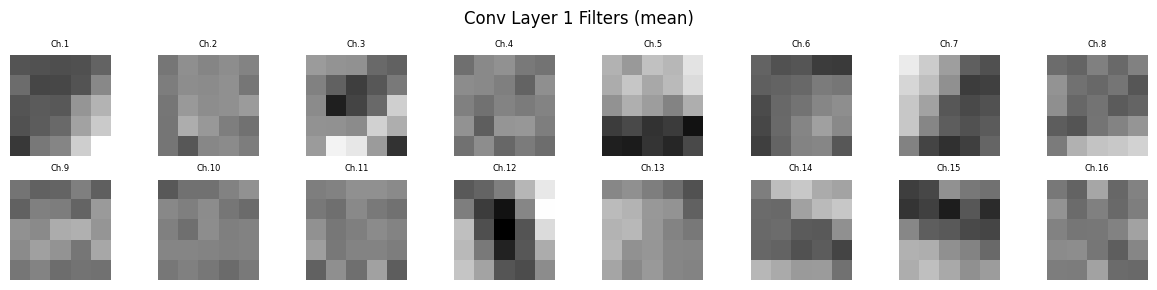

滤波器形状：(32, 16, 5, 5) (层2)


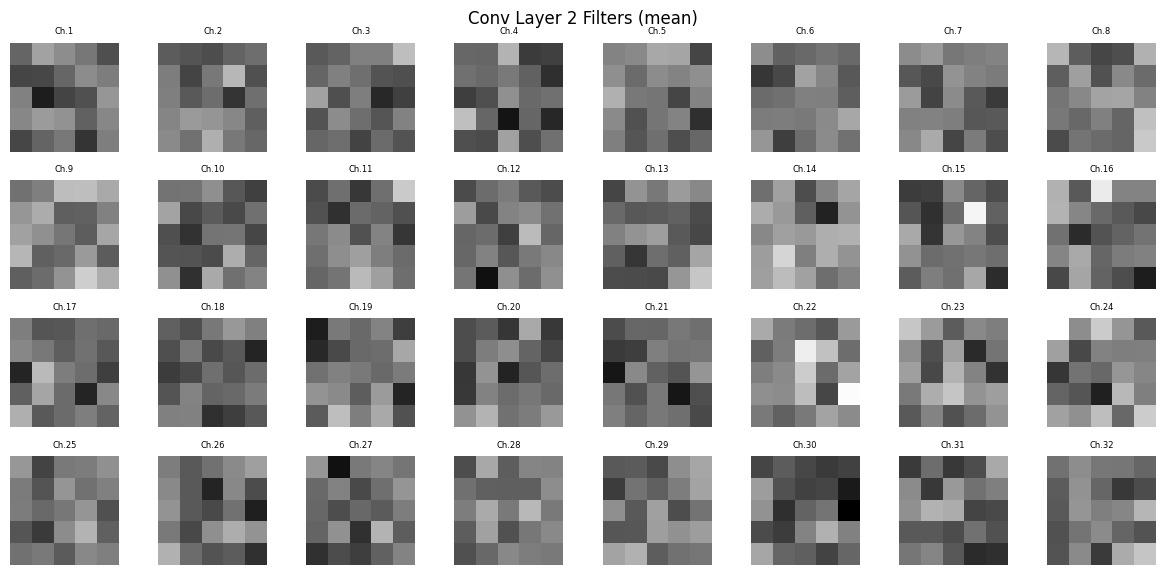

In [5]:
# 可视化第一层
visualize_filters(model, layer_idx=0)

# 可视化第二层（均值模式）
visualize_filters(model, layer_idx=1, mode='mean')

## 特征图

数据准备：

In [24]:
import mynn as nn
from draw_tools.plot import plot

import numpy as np
from struct import unpack
import gzip
import matplotlib.pyplot as plt
import pickle

# fixed seed for experiment
np.random.seed(309)

train_images_path = r'.\dataset\MNIST\train-images-idx3-ubyte.gz'
train_labels_path = r'.\dataset\MNIST\train-labels-idx1-ubyte.gz'

with gzip.open(train_images_path, 'rb') as f:
        magic, num, rows, cols = unpack('>4I', f.read(16))
        train_imgs=np.frombuffer(f.read(), dtype=np.uint8).reshape(num, 28*28)
    
with gzip.open(train_labels_path, 'rb') as f:
        magic, num = unpack('>2I', f.read(8))
        train_labs = np.frombuffer(f.read(), dtype=np.uint8)


# choose 10000 samples from train set as validation set.
idx = np.random.permutation(np.arange(num))
# save the index.
with open('idx.pickle', 'wb') as f:
        pickle.dump(idx, f)
train_imgs = train_imgs[idx]
train_labs = train_labs[idx]
valid_imgs = train_imgs[:10000]
valid_labs = train_labs[:10000]
train_imgs = train_imgs[10000:]
train_labs = train_labs[10000:]

# normalize from [0, 255] to [0, 1]
train_imgs = train_imgs / train_imgs.max()
valid_imgs = valid_imgs / valid_imgs.max()

train_imgs = train_imgs.reshape(-1, 1, 28, 28)  # 转换为[N, C, H, W]格式

In [53]:
def get_digit_sample(digit=9, images=train_imgs, labels=train_labs):
    # 查找第一个符合条件的样本索引
    indices = np.where(labels == digit)[0]
    assert len(indices) > 0, f"数据集中没有数字{digit}的样本"
    sample_idx = indices[0]
    
    # 提取并预处理样本
    sample_img = images[sample_idx].reshape(1, 1, 28, 28)  # [1,1,28,28]
    return sample_img

def visualize_digit_feature_maps(model, sample):
    # 前向传播获取特征图
    activations = []
    x = sample
    for layer in model.layers:
        x = layer(x)
        if isinstance(layer, (nn.op.conv2D, nn.op.PoolLayer)):  # 包含卷积和池化层
            activations.append(x[0])  # 取第一个样本
    
    # 可视化每个卷积/池化层的特征图
    layer_names = ['Conv1', 'Pool1', 'Conv2', 'Pool2']
    for i, (feat_map, layer_name) in enumerate(zip(activations, layer_names)):
        plt.figure(figsize=(12, 12))
        plt.suptitle(f"{layer_name} Feature Maps (Digit 9)", y=1.02, fontsize=20)
        
        # 显示前16个通道
        n_channels = min(16, feat_map.shape[0])
        for j in range(n_channels):
            plt.subplot(4, 4, j+1)
            
            # 根据层类型调整显示方式
            if 'Pool' in layer_name:
                plt.imshow(feat_map[j], cmap='viridis', interpolation='nearest')
            else:
                plt.imshow(feat_map[j], cmap='gray', interpolation='bilinear')
                
            plt.axis('off')
            plt.title(f"Ch.{j+1}", fontsize=8)
        
        plt.tight_layout()
        plt.show()


执行可视化：

输入数字9的原图: 


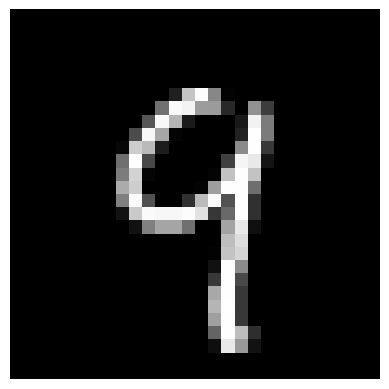


各层特征图可视化: 


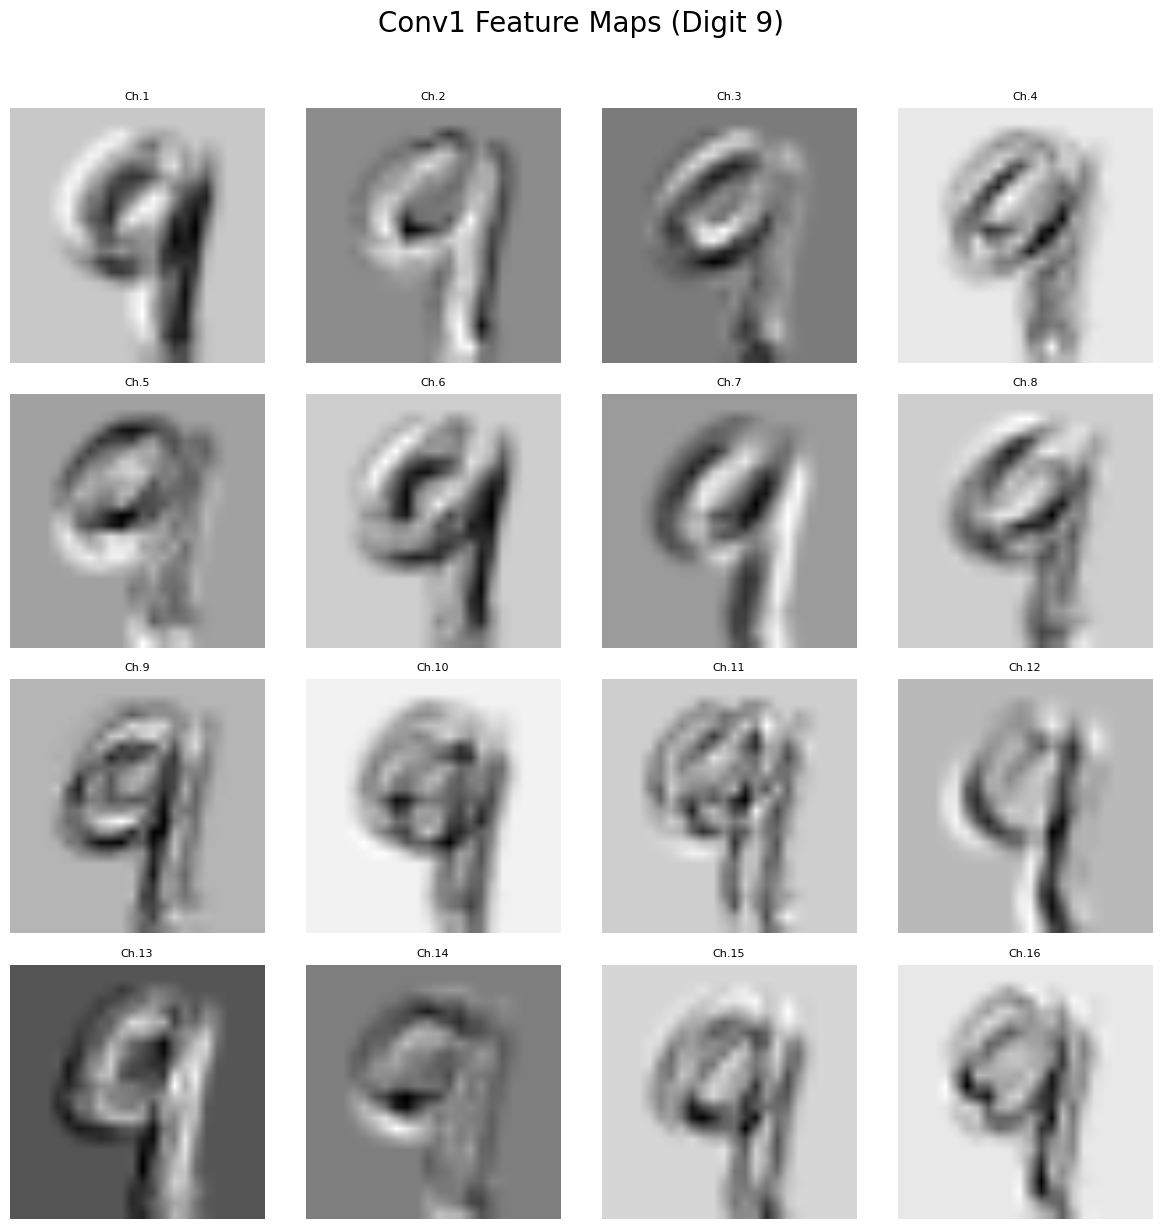

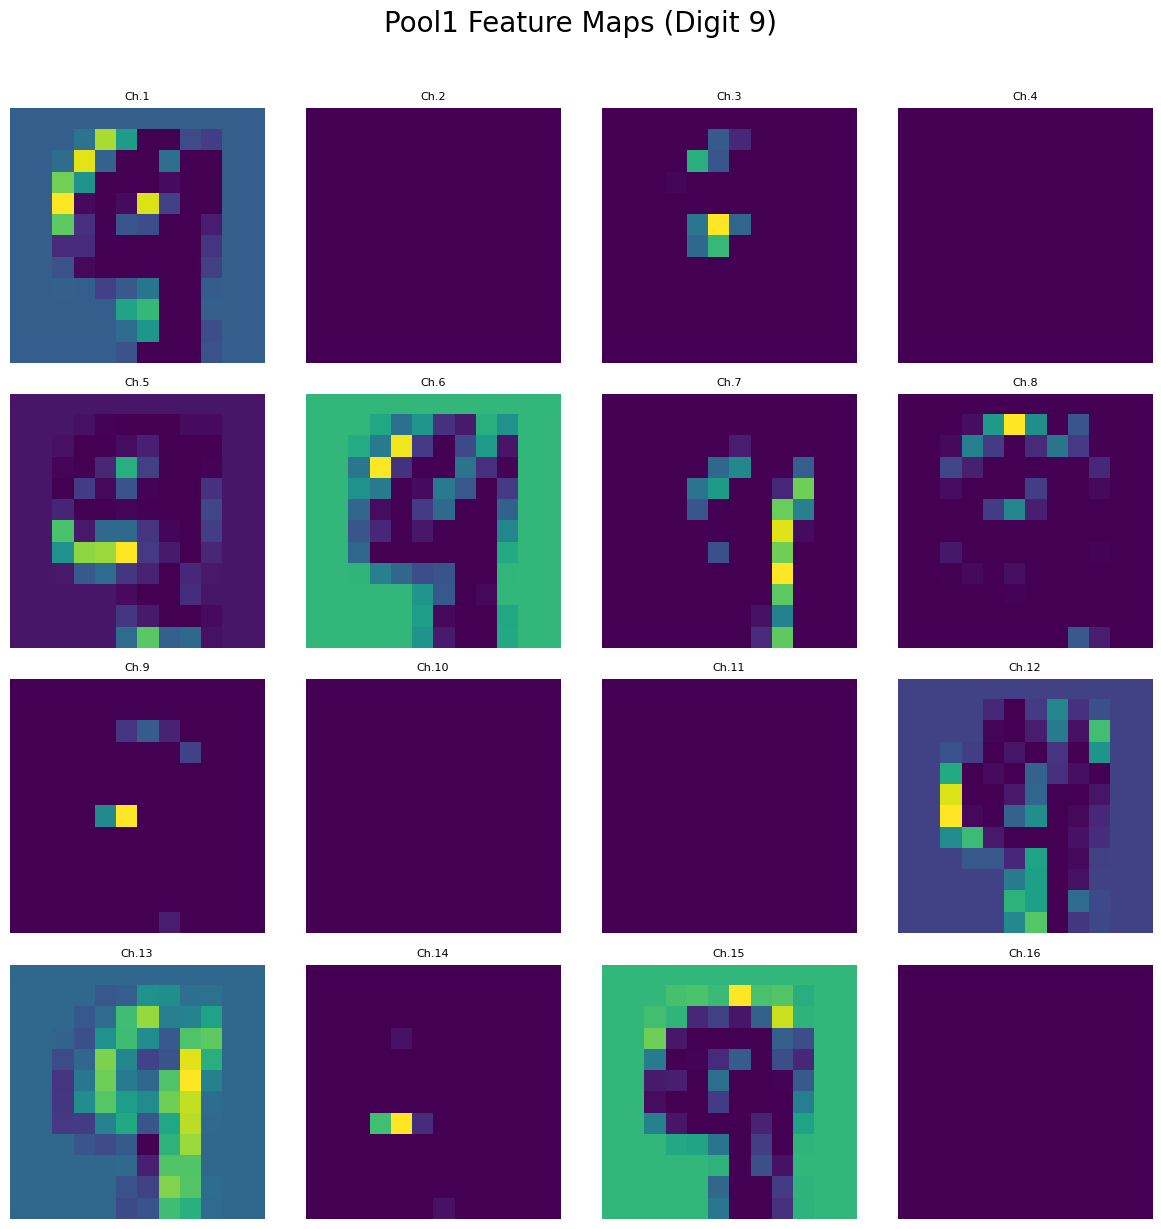

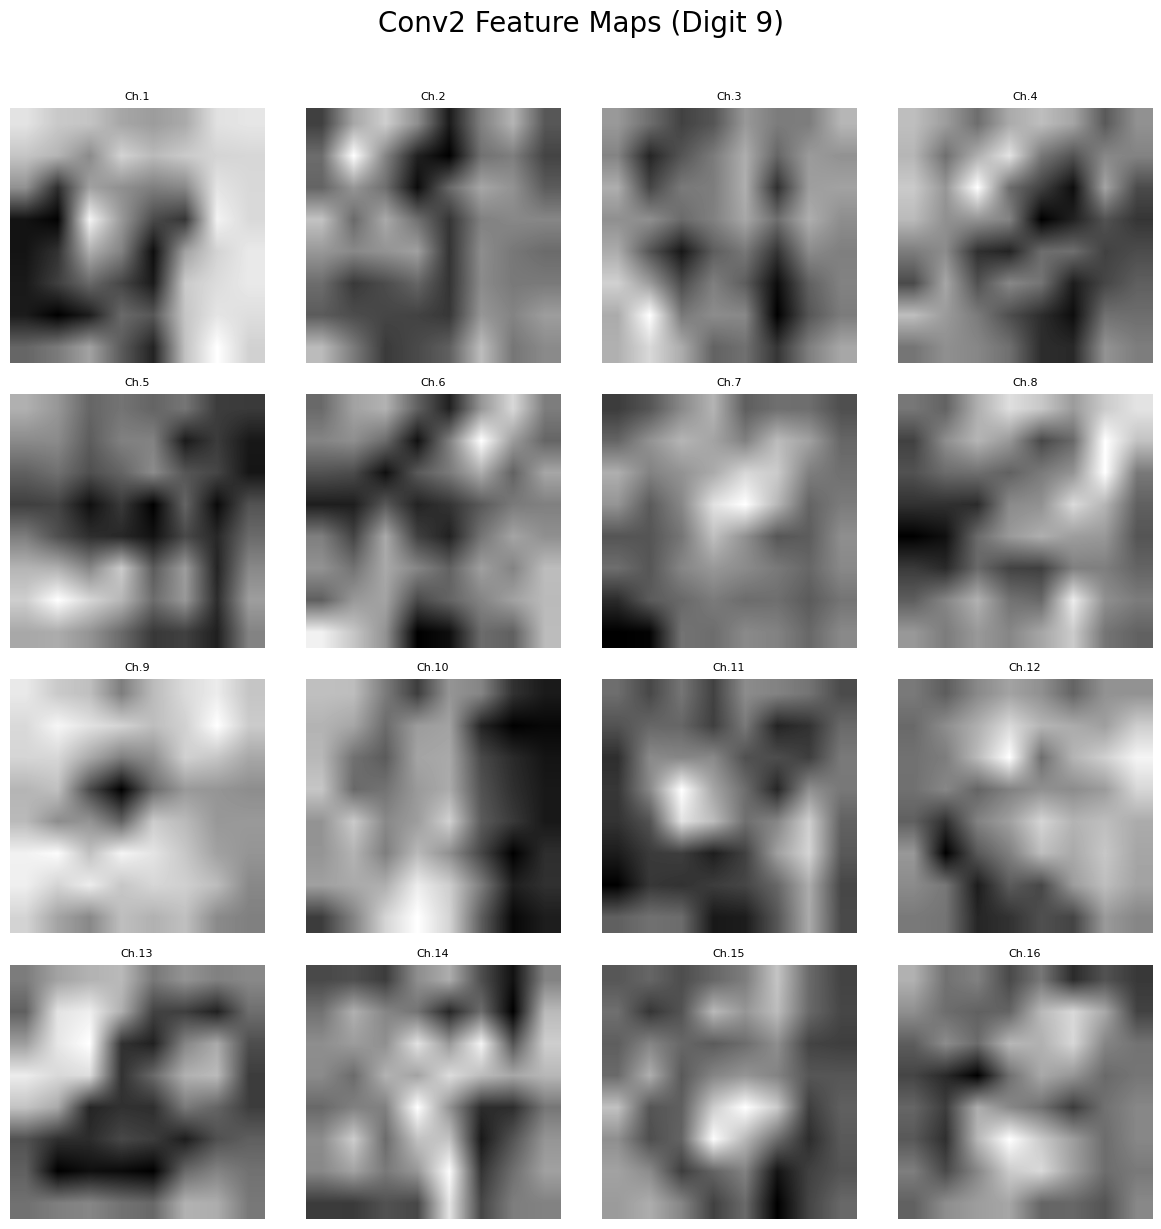

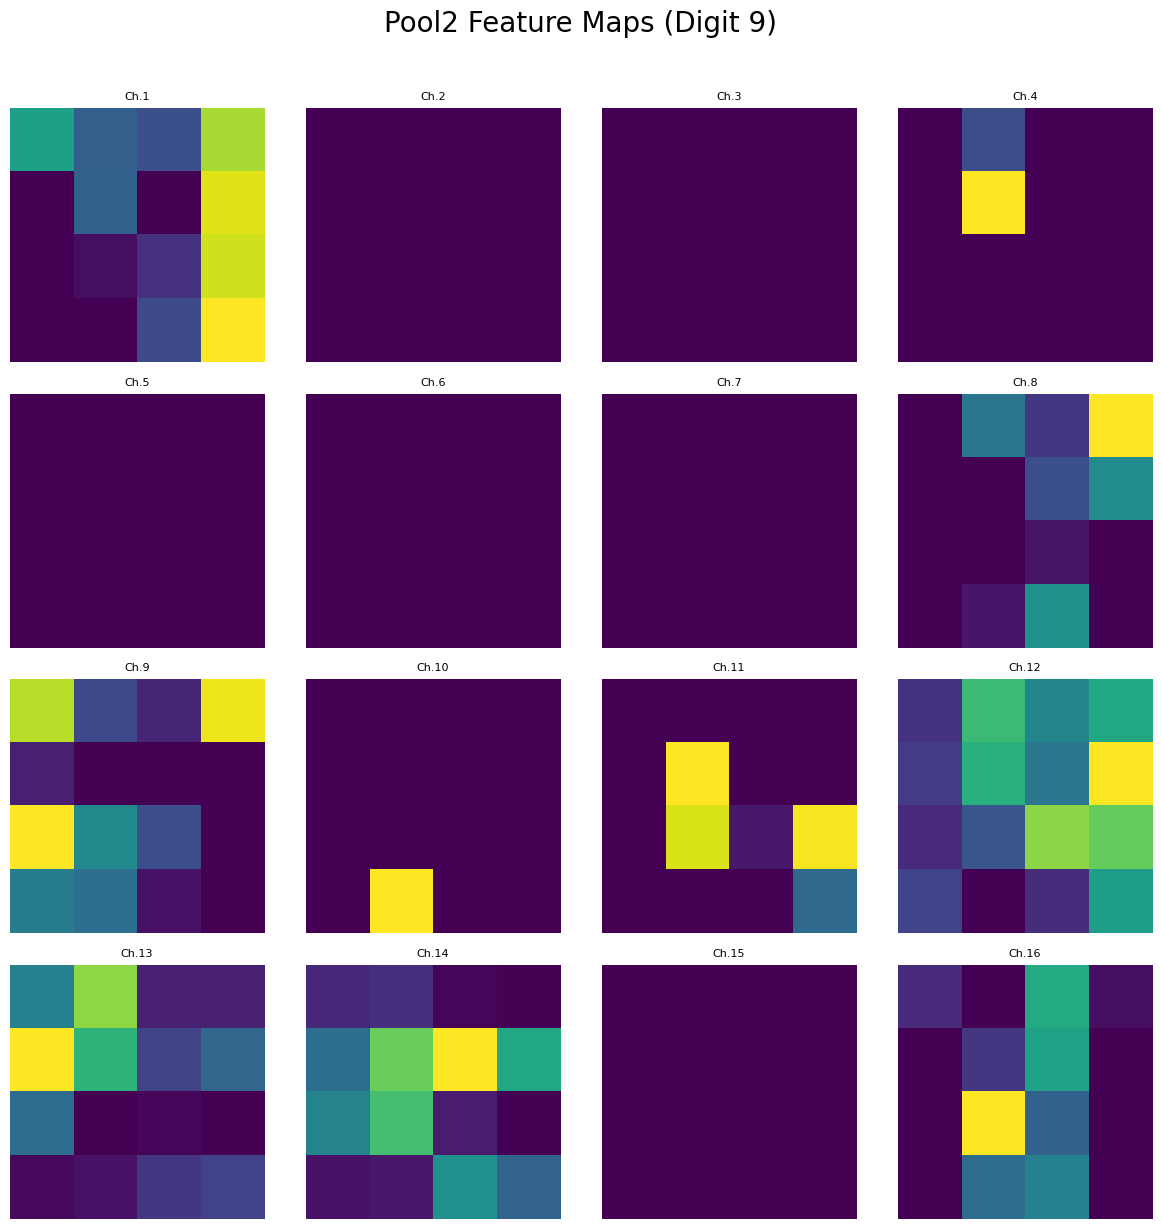

In [54]:
digit_9_sample = get_digit_sample(9)

print("输入数字9的原图: ")
plt.imshow(digit_9_sample[0,0], cmap='gray')
plt.axis('off')
plt.show()

print("\n各层特征图可视化: ")
visualize_digit_feature_maps(model, digit_9_sample)

输入数字1的原图: 


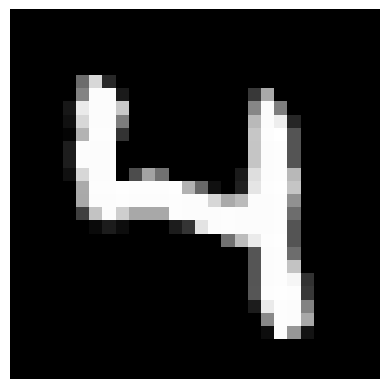


各层特征图可视化: 


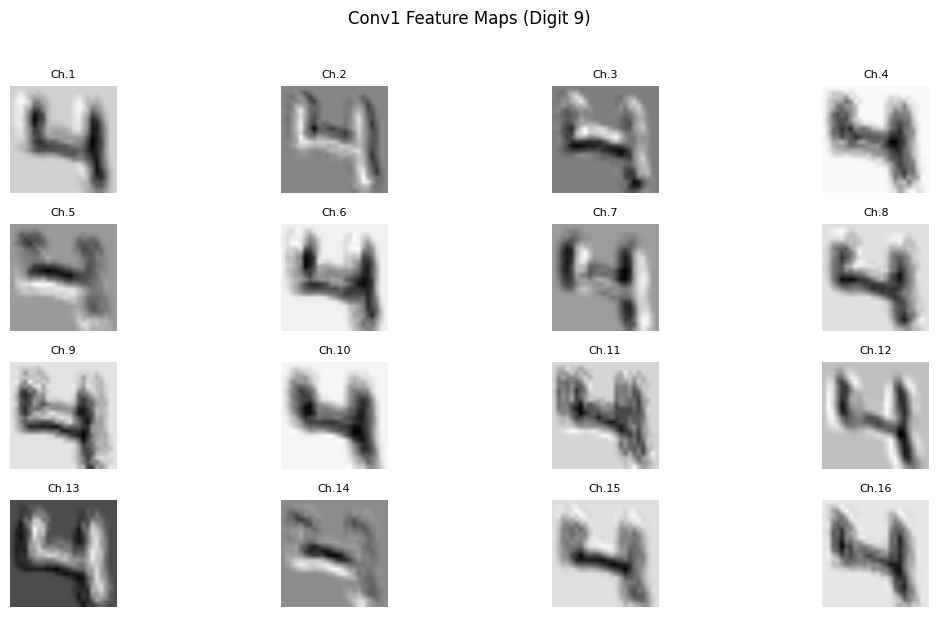

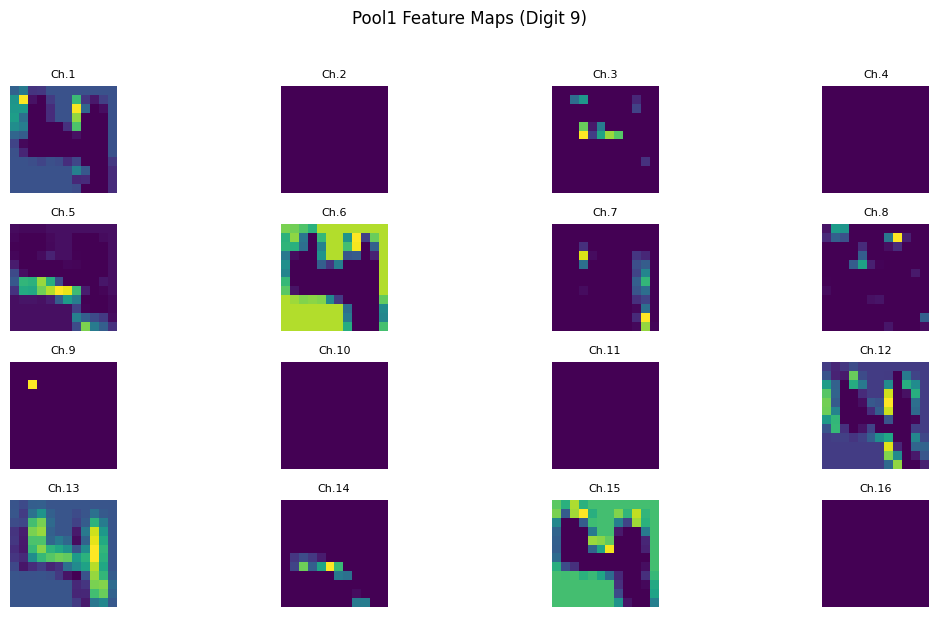

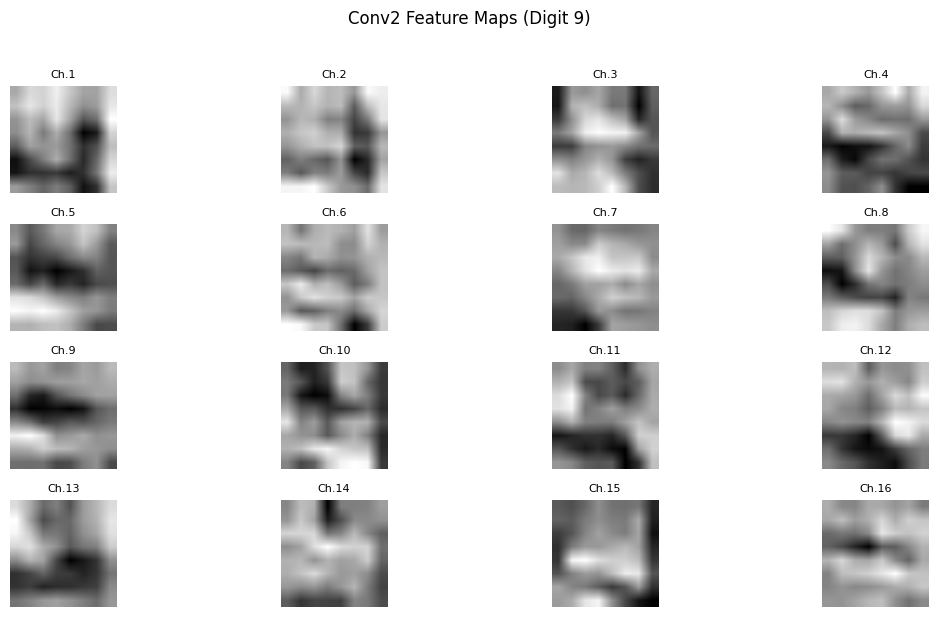

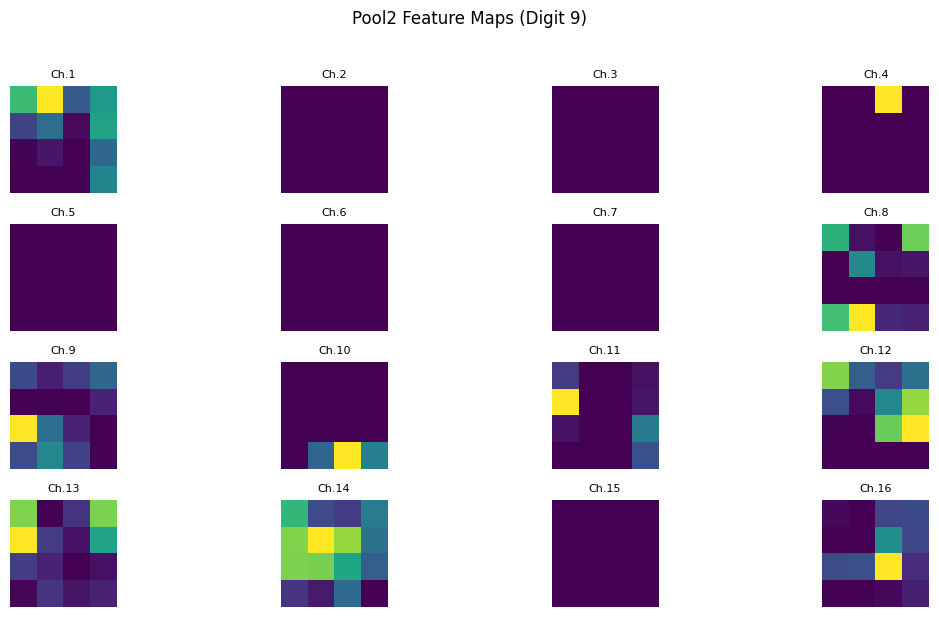

In [44]:
digit_4_sample = get_digit_sample(4)

print("输入数字1的原图: ")
plt.imshow(digit_4_sample[0,0], cmap='gray')
plt.axis('off')
plt.show()

print("\n各层特征图可视化: ")
visualize_digit_feature_maps(model, digit_4_sample)